# Example 1 (from README)

In [1]:
from src.urls import crawlPrivacy, filterPrivacy
from src.text import findPolicy
status, urls = crawlPrivacy('www.aa.com',clicks=2) # crawls candidate URLs
ranked = filterPrivacy(sum(urls,[])) # filter and rank by likelihood of being privacy policy
status, policy, url = findPolicy(ranked) # scrape highest ranked page that contains 'privacy'

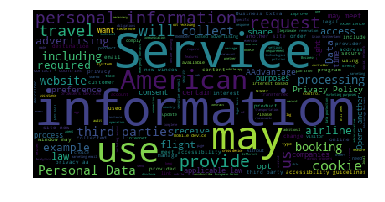

In [2]:
%matplotlib inline
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wc = WordCloud()
wc.generate(' '.join(policy))
plt.imshow(wc); plt.axis('off')
plt.savefig('aa_wc.png')

In [3]:
from src.attributes import isVisible, fogIndex, policyLength
visible = isVisible('www.aa.com')
fog = fogIndex(' '.join(policy))
pars, words = policyLength(policy)

# output
print('\n')
# is 'privacy' visible on main website?
print('Privacy is visible on main website' if visible else 'Privacy is not visible on main website')
# gunning fog index
print('Fog index is %.2f' % fog)
# length
print('Policy contains %d paragraphs and %d words' % (pars,words))

TEXT IS NOT BEING PRE PROCESSED
type(text) == <type 'unicode'> ; Size Text: 36697


Privacy is visible on main website
Fog index is 20.91
Policy contains 107 paragraphs and 5751 words


# Example 2: Legal clarity
Our legal clarity index is an ordinal measure, defined relative to a corpus of policies (this is because it is based on the relative TF.IDF frequency of certain terms in each document)

In this example, we crawl two websites to make a mini corpus and calculate the legal clarity of their policies.

*Warning*: For these two websites, our scraping method works fine, so that `status==True` for both. When applying this to wide lists of websites, the code needs to be modified to handle errors.

In [4]:
from src.urls import crawlPrivacy, filterPrivacy
from src.text import findPolicy
from src.attributes import legalClarity

sites = ['www.aa.com','www.ba.com']

# loop to find URLs
status, urls = {} , {}
for dom in sites:
    status[dom], urls[dom] = crawlPrivacy(dom,clicks=2) 
    
# loop to get policies
policies = {}
for dom in sites:
    ranked = filterPrivacy(sum(urls[dom],[])) 
    _, policies[dom], _ = findPolicy(ranked)
    
# legal clarity index
lc = legalClarity(policies)
for dom in sites:
    print('Legal clarity of %s: %.3f' % (dom,lc[dom]))

Legal clarity of www.aa.com: 1.005
Legal clarity of www.ba.com: 1.886


# Detail: URLs module
This module contains functions that find candidate URLs to privacy policies on a website

In [5]:
# crawl website (this takes a while for clicks > 1)
from src.urls import crawlPrivacy
status, urls = crawlPrivacy('www.aa.com',clicks=2)

# result is a list of lists of URLs, ordered by number of clicks 
# e.g., the first list urls[0] contains the links accessible with one click
for i,x in enumerate(urls):
    print('Crawler finds %d URLs with %d click(s)' % (len(x),i+1))

Crawler finds 64 URLs with 1 click(s)
Crawler finds 341 URLs with 2 click(s)


In [6]:
# filter the URLs 
from src.urls import filterPrivacy
ranked = filterPrivacy(sum(urls,[]))

# result is a list of URLs ranked from high to low likelihood of being a privacy policy
# see /src/urls.py for definition of this filter
print('Top 5 candidate URLs from crawler:\n' + '\n'.join(ranked[0:5]))

Top 5 candidate URLs from crawler:
http://www.aa.com//i18n/customer-service/support/privacy-policy.jsp
http://www.aa.com/i18n/customer-service/support/privacy-policy.jsp
http://www.aa.com/i18n/customer-service/support/legal-privacy-copyright.jsp?locale=en_GB
http://www.aa.com/travelInformation/flights/status?anchorEvent=false&from=Nav
http://www.aa.com/travelInformation/flights/schedule


In [7]:
# alternative method: perform site-specific serch for 'privacy' with Google Custom Search
from src.urls import googlePrivacy

# credentials needed!
my_api_key = ""
my_cse_id = ""

# arguments: num = number of results, gl = location, lr = language
status, result = googlePrivacy(dom, my_api_key, my_cse_id, num=5, gl = 'us', lr = 'lang_en')

# result is a list of seach result URLs 
print('Links found on Google:\n' + '\n'.join(result))

Links found on Google:
https://careers.ba.com/privacy-policy
https://www.shopping.ba.com/privacy.html
https://www.shopping.ba.com/cookies
http://www.ba.com/main/TERMCN
http://www.ba.com/main/COOKIES


# Detail: Text module
This module contains functions to download privacy policies (given candidate URLs) and cleans them

In [8]:
from src.text import findPolicy, cleanPolicy

In [9]:
# from a ranked list of URLs, scrape first webpage that contains 'privacy'
status, policy, url = findPolicy(ranked)

# result is a list of paragraphs and the URL where they were found
if status: 
    print('Policy found at %s, with %d paragraphs \n' % (url,len(policy)))
    print('First 3 paragraphs:\n\n' + '\n\n'.join(policy[0:3]))

Policy found at http://www.aa.com//i18n/customer-service/support/privacy-policy.jsp, with 107 paragraphs 

First 3 paragraphs:

Buy, gift or share miles , Opens another site in a new window that may not meet accessibility guidelines.

This Privacy Policy explains how American Airlines, Inc. ("we," "us," "our," "American") collects, uses, shares, and protects information in connection with American’s services, systems, websites, and apps that refer or link to this Privacy Policy (our "Services"), including without limitation, the collection and processing of personal information in connection with bookings and travel on American Airlines or flights operated by our regional carriers (for example, Envoy Air, Piedmont Airlines and PSA Airlines). This Privacy Policy applies regardless of the type of device or other means you use to access our Services.

American reserves the right to change this Privacy Policy at any time by posting the updated Policy here along with the date on which the P

In [10]:
# clean up text for natural language processing
tokens, lemmas = cleanPolicy(policy)

# results is a list of lists of lemmas (one list for each paragraph)
print('Lemmas in first 3 paragraphs:\n')
print('\n\n'.join([','.join(l) for l in lemmas[0:3]]))

Lemmas in first 3 paragraphs:

buy,gift,share,mile,open,another,site,new,window,may,meet,accessibility,guideline

privacy,policy,explains,airline,inc,u,collect,us,share,protects,information,connection,service,system,website,refer,link,including,without,limitation,collection,processing,personal,booking,travel,flight,operated,regional,carrier,example,envoy,air,piedmont,applies,regardless,type,device,mean,use,access

reserve,right,change,privacy,policy,time,posting,updated,along,date,changed,make,material,affect,way,collect,use,share,personal,information,notify,including,newly,label,link,day,made
